# Histopathologic Cancer Detection
Cancer detection is an important area in the field of biomedical data science. AI-assisted classification of tissues can help physicians detect cancerous tissues, preventing false negatives and speeding up medical diagnostics. Here, we utilize Convolutional Neural Networks (CNNs) to help classify the cancer tissue. We will train and evaluate a number of CNN architectures. In consideration of time and resources, architectures may be implemented in a slightly modified form.
1. A **VGG-16** architecture strings together 2 convolutions with 3x3 filters and a 2x2 max pool and 3 convolutions with 3x3 filters and another 2x2 max pool. The output is then fed to multiple dense layers for classification.<br>
    ![VGG-16](../assets/vgg-16.png)
2. An **AlexNet** architectures begins with an 11x11 convolutional filter followed by a 3x3 max pool. This is followed by a smaller, 5x5 convolution and another 3x3 max pool. Last, a series of 3 3x3 convolutions is followed by a final 3x3 max pool. For classification, multiple dense layers follow.<br>
    ![AlexNet](../assets/alex-net.png)
3. The simpler **LeNet-5** architecture uses strings together 2 5x5 convolutional layers followed by a 2x2 avg pool. For classification, it is followed by several dense layers.<br>
    ![LeNet-5](../assets/le-net.png)
    
To manage the machine-learning lifecycle, we will use [MLFlow](https://www.mlflow.org/docs/latest/index.html) for end-to-end machine-learning lifecylces, from inception, to deployment. This allows us to track our models and experiments, build machine-learning pipelines, among much more.

## Data Source and Ingestion
A script is provided in `src/pipeline/data-ingestion.sh` for loading the data. This utilizes the Kaggle CLI to download the data, then simply unzips it into the the `src/data/` directory. All in all, it contains a training and a testing set. The entire file structure is shown belown.
```
.
├── assets
└── src
    ├── data
    │   ├── test
    │   └── train
    └── pipeline
```

Here, we perform some necessary preliminary actions: loading packages, obtaining the directory and file paths for the source directory, the data directory, the data training directory, the data testing directory, and the metadata files containing the training labels for each respective training image. The `train_labels.csv` is loaded in as a Pandas dataframe, and we append the full path of the image to the dataframe to streamline data ingestion.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import os

from PIL import Image

from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

np.set_printoptions(precision=3)

print(tf.config.list_physical_devices('GPU'))

[]


2022-09-14 18:08:06.806194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 18:08:06.839327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-09-14 18:08:06.843423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-14 18:08:06.843445: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required

In [3]:
# Obtain relevant paths
DIR_SRC = os.getcwd()
DIR_DATA = f"{DIR_SRC}/data"
DIR_DATA_TRAIN = f"{DIR_DATA}/train"
DIR_DATA_TEST = f"{DIR_DATA}/test"

# Store the location of our training labels dataset
FILE_METADATA_TRAIN = f"{DIR_DATA}/train_labels.csv"

In [4]:
print(f"""\
Source Directory:     {DIR_SRC}
Data Directory:       {DIR_DATA}
Data Train Directory: {DIR_DATA_TRAIN}
Data Test Directory:  {DIR_DATA_TEST}
Training Labels File: {FILE_METADATA_TRAIN}
""")

Source Directory:     /home/benjamin/Git/histopathologic-caner-detection/src
Data Directory:       /home/benjamin/Git/histopathologic-caner-detection/src/data
Data Train Directory: /home/benjamin/Git/histopathologic-caner-detection/src/data/train
Data Test Directory:  /home/benjamin/Git/histopathologic-caner-detection/src/data/test
Training Labels File: /home/benjamin/Git/histopathologic-caner-detection/src/data/train_labels.csv



In [5]:
# Load in the training labels as a pandas dataframe
METADATA_TRAIN = pd.read_csv(FILE_METADATA_TRAIN)

# Add in the full path to the id, so we can grab it easier
METADATA_TRAIN["path"] = DIR_DATA_TRAIN + "/" + METADATA_TRAIN["id"] + ".tif"

In [6]:
METADATA_TRAIN.head(10)

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,/home/benjamin/Git/histopathologic-caner-detec...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/home/benjamin/Git/histopathologic-caner-detec...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/home/benjamin/Git/histopathologic-caner-detec...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/home/benjamin/Git/histopathologic-caner-detec...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/home/benjamin/Git/histopathologic-caner-detec...
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0,/home/benjamin/Git/histopathologic-caner-detec...
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1,/home/benjamin/Git/histopathologic-caner-detec...
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1,/home/benjamin/Git/histopathologic-caner-detec...
8,559e55a64c9ba828f700e948f6886f4cea919261,0,/home/benjamin/Git/histopathologic-caner-detec...
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0,/home/benjamin/Git/histopathologic-caner-detec...


## Exploratory Data Analysis
An exploratory data analysis on images may be difficult to perform. However, there are a few things we can do to ensure that model building will go well: We can display random images alongside their label to gain an intuitive idea of what we are trying to achieve, and we can plot a histogram of the training label frequencies to see how much data we actually have and how balanced our classes are.

In [7]:
def tif_to_numpy(fname):
    """Load a .tif image as a NumPy array given the file name.
    """
    # Load the tif as an Image
    image = Image.open(fname)
    return np.asarray(image)

def display_random_images(metadata_train, n=3):
    """Display n*n random images as a matplotlib figure from the train_csv dataframe
    """
    n2 = n * n
    indices = random.sample(range(n2), n2)
    
    # Extract the images and their label
    image_labels = [metadata_train["label"][i] for i in indices]
    
    # Load in the images
    images = [tif_to_numpy(metadata_train["path"][i]) for i in indices]
    
    # Display each image in a subplot
    fig, ax = plt.subplots(figsize=(4*n, 4*n), ncols=n, nrows=n, tight_layout=True)
    
    # k will serve as a pointer to our image and label
    k = 0
    
    for i in range(n):
        for j in range(n):
            # Plot the individual image in an axis
            ax[i, j].axis("off")
            ax[i, j].imshow(images[k])
            ax[i, j].set_title(f"Label: {image_labels[k]}")
            
            k += 1

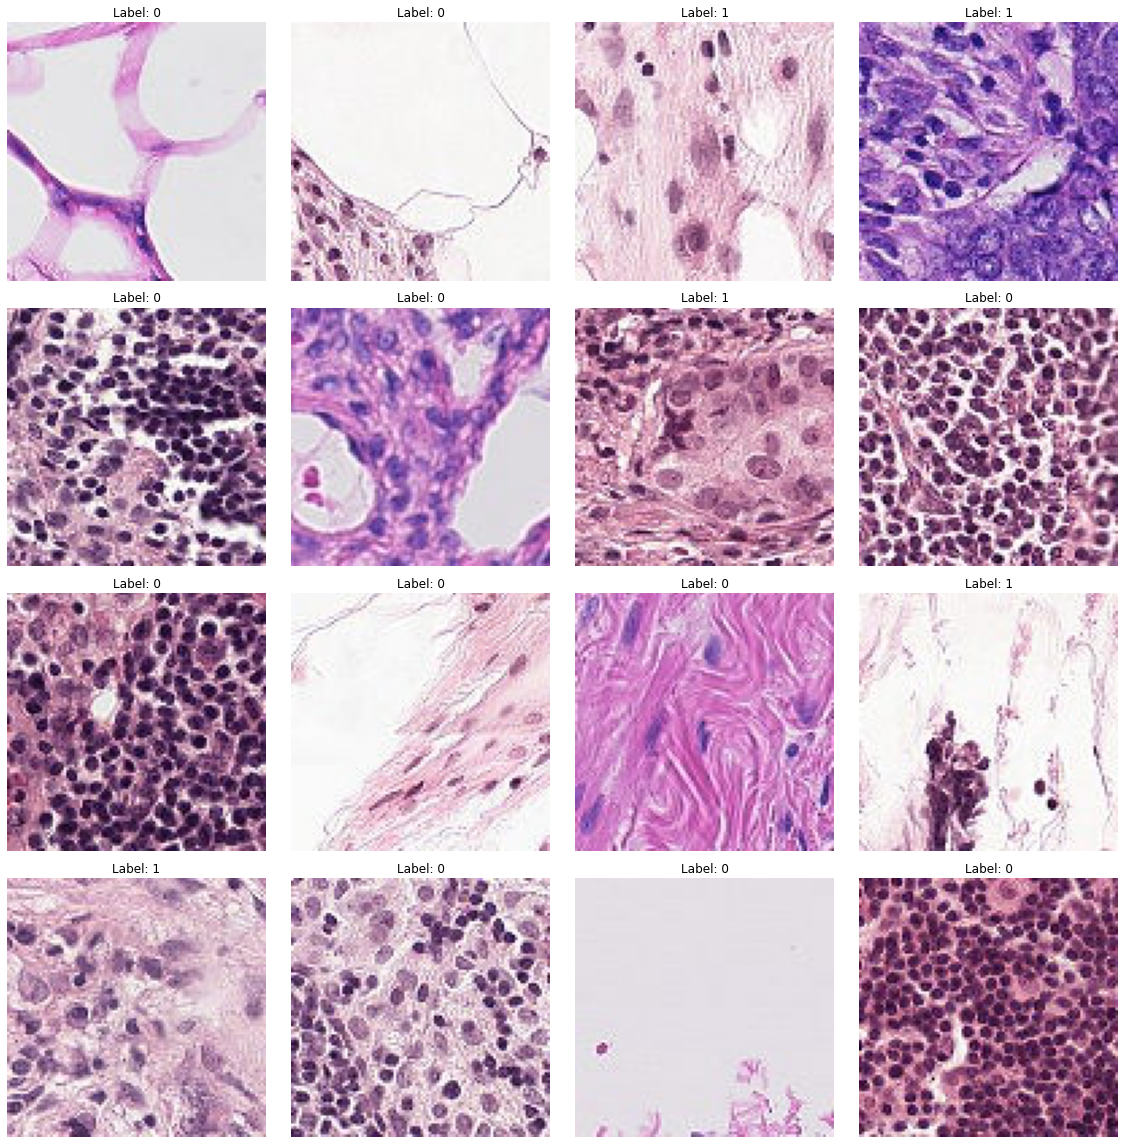

In [8]:
display_random_images(METADATA_TRAIN, n=4)

<AxesSubplot:title={'center':'Training Label Frequency'}, xlabel='Training Label', ylabel='Frequency'>

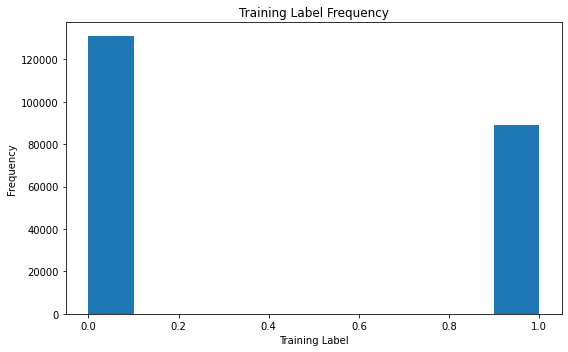

In [9]:
# Generate a figure to determine the distribution of training labels
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.set_xlabel("Training Label")
ax.set_ylabel("Frequency")
ax.set_title("Training Label Frequency")

METADATA_TRAIN["label"].hist(grid=False, ax=ax)

## Data Preprocessing
We will utilize TensorFlow datasets to preprocess our data. Image data will benefit from normalization and will require shuffling to ensure that the data is i.i.d. We will also split the training data to include a validation set to help tune our CNN models.

In [90]:
# Create the full dataset of the metadata
IMAGE_PATHS = METADATA_TRAIN["path"]
IMAGE_LABELS = METADATA_TRAIN["label"]


# Create a data generator that we can feed the dataset individual samples without running out of RAM
def image_generator():
    """Utilize the IMAGE_PATHS and IMAGE_LABELS global variables to load images
    in a generator form. This avoids memory overflow from processing all images
    at once.
    """
    for path, label in zip(IMAGE_PATHS, IMAGE_LABELS):
        image = tif_to_numpy(path)
        yield (image, label)
        

# TODO: apply image_z = (image - mean(image) / std(image))... Tensors are hard
def normalization(image):
    """Normalize an image across each RGB channel using the z-score.
    
    Parameters
    ----------
    image : tf.tensor
        The input image
    
    Returns
    -------
    image_z : tf.tensor
        The z-score normalized image
    """ 
    # Compute the mean of each channel
    mean = tf.math.reduce_mean(image, axis=2)
    std = tf.math.reduce_std(image, axis=2)
    tf.math.reduce_sum(x, mean)
        
# Generate our full dataset from our generator function
DATASET_FULL = tf.data.Dataset.from_generator(
    image_generator,
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float64),
        tf.TensorSpec(shape=(), dtype=tf.float64)
    )
)

# Normalize each image in the dataset
DATASET_FULL = DATASET_FULL.map(lambda x, y: (normalization(x), y))

TypeError: in user code:

    File "/tmp/ipykernel_693385/2176431203.py", line 46, in None  *
        lambda x, y: (normalization(x), y)
    File "/tmp/ipykernel_693385/3853359345.py", line 34, in normalization  *
        tf.math.reduce_sum(x, mean)

    TypeError: Value passed to parameter 'reduction_indices' has DataType float64 not in list of allowed values: int32, int64
